In [43]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

In [44]:
# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

0 {'prob': 1}


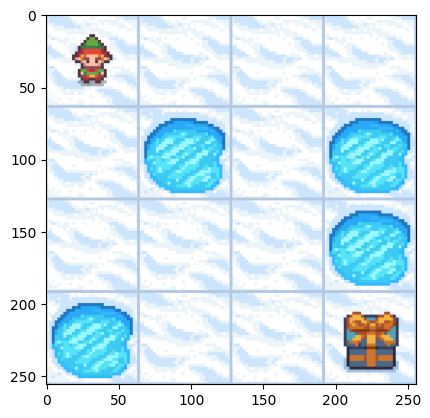

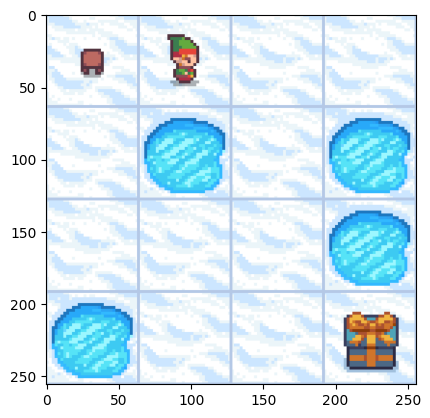

In [45]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

print(observation, info)

img = env.render()
plt.imshow(img)

# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}
plt.figure()
img = env.render()
plt.imshow(img)


In [46]:
class IRLAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

        self.update_count = 0

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def temporal_difference(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ) -> float:
        """Computes the temporal difference error."""
        # max of Q(s', a) over all possible actions a
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        return (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        temporal_difference = self.temporal_difference(
            obs, action, reward, terminated, next_obs
        )
        self.q_values[obs][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)


# hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

from IPython import display

env = gym.make(
    "FrozenLake-v1",
    desc=None,
    map_name="4x4",
    is_slippery=False,
    render_mode="rgb_array",
)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

def train(env, agent, back_prop=False, human_feedback=False, n_episodes=40000):
    human_feedback_count = 0
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        obs_history = []
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            obs_history.append([obs, action, reward, terminated, next_obs])

            if (
                human_feedback
                and reward == 0
                and agent.temporal_difference(obs, action, reward, terminated, next_obs)
                < 0.005
                and episode < 10
            ):
                human_feedback_count += 1
                img = env.render()

                current_col = obs % 4
                current_row = obs // 4

                next_col = next_obs % 4
                next_row = next_obs // 4

                grid_height = img.shape[1] / 4
                grid_width = img.shape[0] / 4

                print(f"Current state: {current_row}, {current_col}")
                print(f"Next state: {next_row}, {next_col}")
                display.clear_output(wait=True)
                plt.figure()
                plt.imshow(img)
                plt.arrow(
                    current_col * grid_width + grid_width / 2,
                    current_row * grid_height + grid_height / 2,
                    (next_col - current_col) * grid_width,
                    (next_row - current_row) * grid_height,
                    head_width=10,
                    head_length=10,
                    fc="r",
                    ec="r",
                )
                display.display(plt.gcf())
                a = input("Was the agent's action correct? (y/n)")
                if a == "y":
                    reward = 1
                elif a == "q":
                    break

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        # back prop the reward
        if back_prop:
            for obs, action, reward, terminated, next_obs in reversed(obs_history):
                agent.update(obs, action, reward, terminated, next_obs)

        agent.decay_epsilon()

    print(human_feedback_count)

In [47]:
def plot_stats(env_agent_pairs):
    rolling_length = 500
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")

    for env, agent in env_agent_pairs:
        # compute and assign a rolling average of the data to provide a smoother graph
        reward_moving_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

    plt.tight_layout()
    plt.show()


In [48]:
# hyperparameters
learning_rate = 0.01
n_episodes = 40000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent_baseline = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

from IPython import display

env = gym.make(
    "FrozenLake-v1",
    desc=None,
    map_name="4x4",
    is_slippery=False,
    render_mode="rgb_array",
)
env_baseline = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
train(env_baseline, agent_baseline, n_episodes=25000)

agent_backprop = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)
env_backprop = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
train(env_backprop, agent_backprop, n_episodes=25000, back_prop=True)


100%|██████████| 25000/25000 [00:06<00:00, 3996.63it/s]


0


100%|██████████| 25000/25000 [00:07<00:00, 3569.26it/s]

0


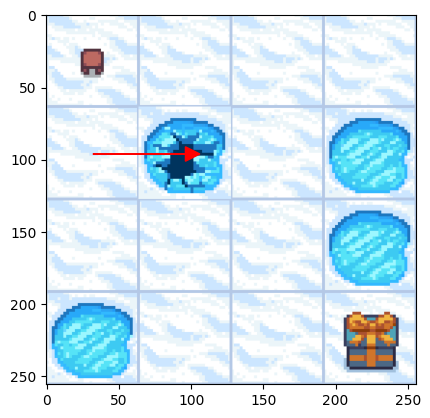

100%|██████████| 25000/25000 [01:12<00:00, 345.07it/s] 


38


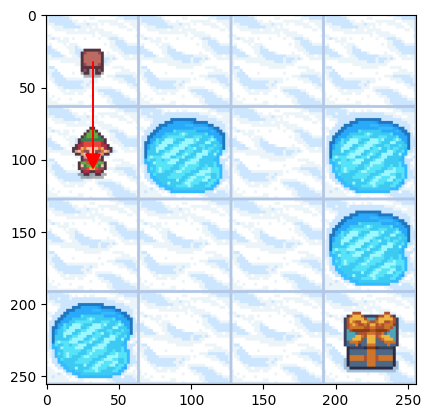

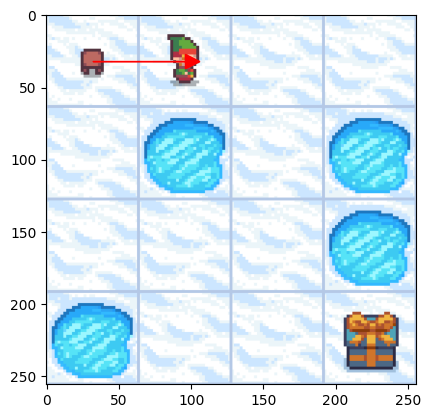

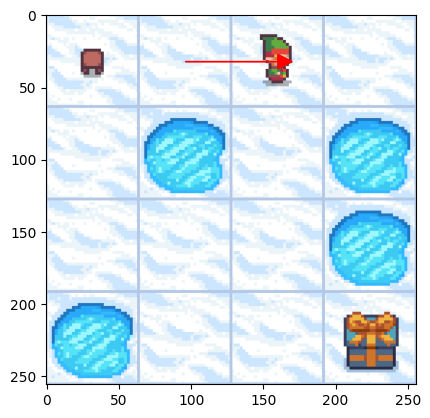

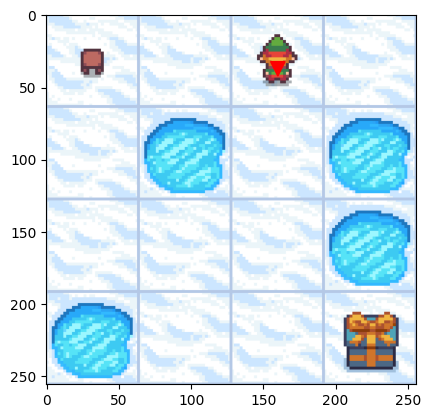

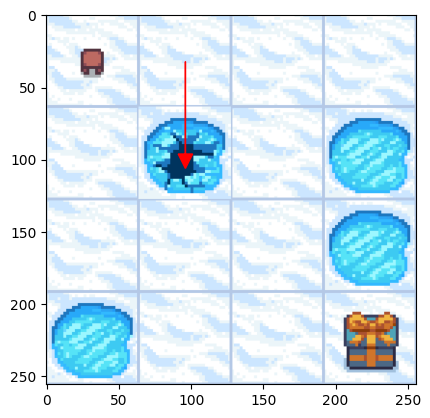

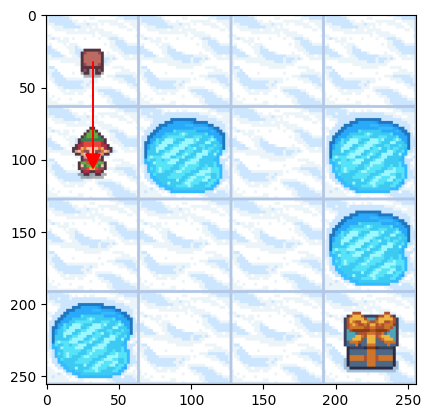

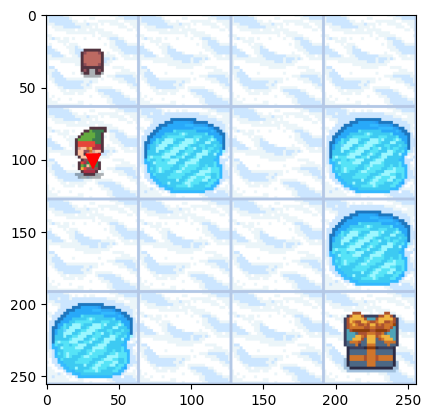

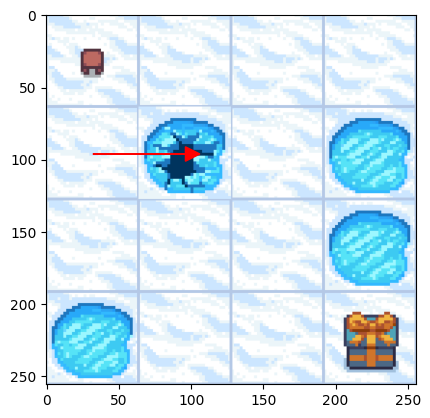

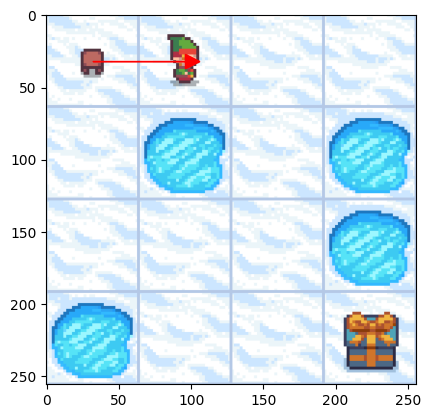

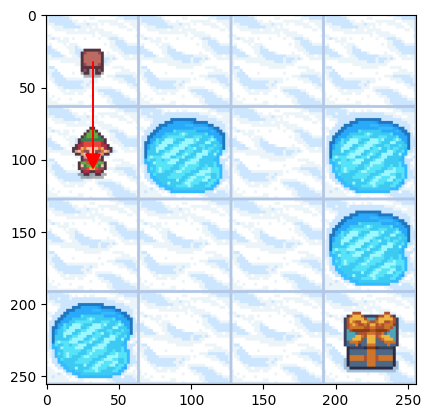

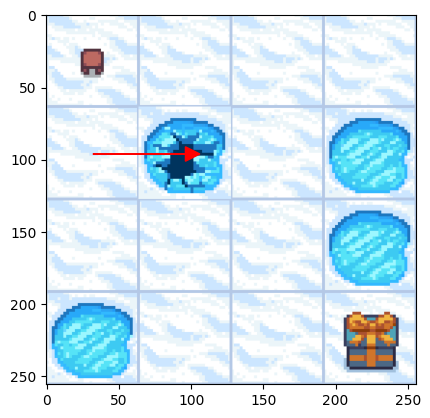

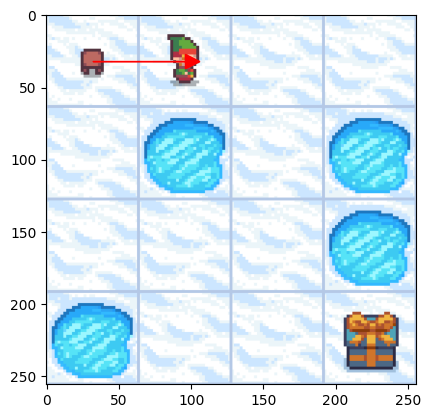

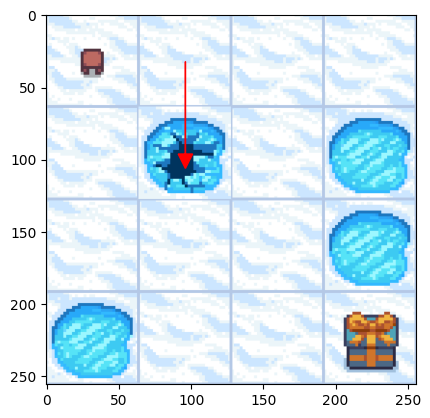

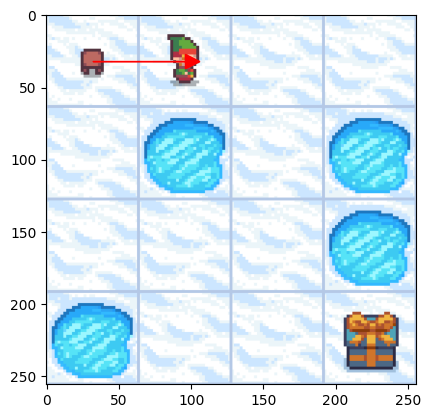

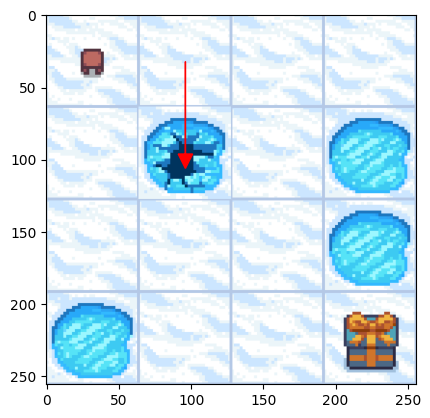

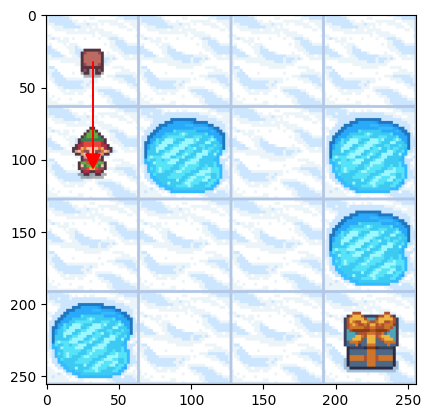

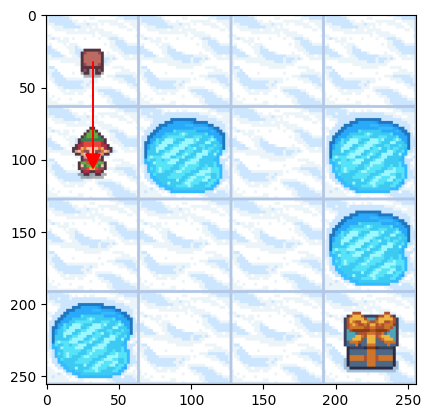

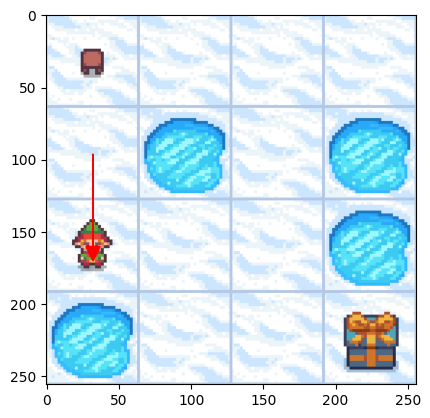

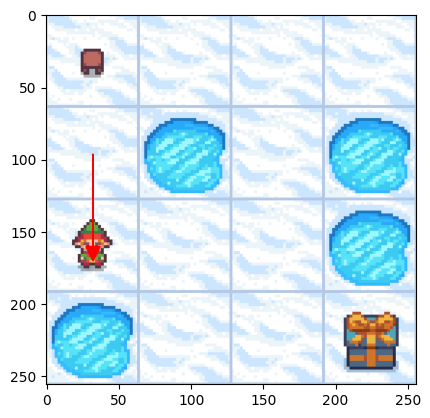

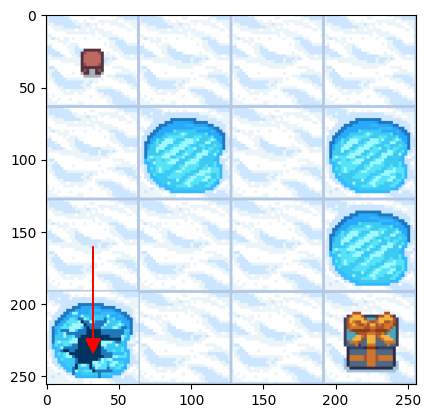

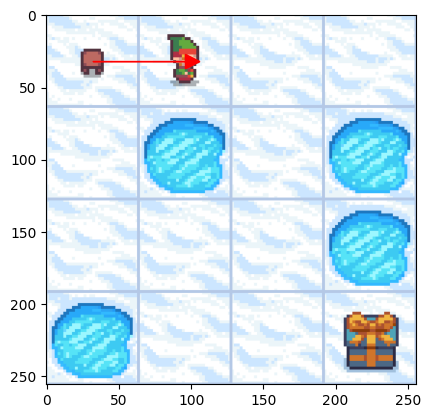

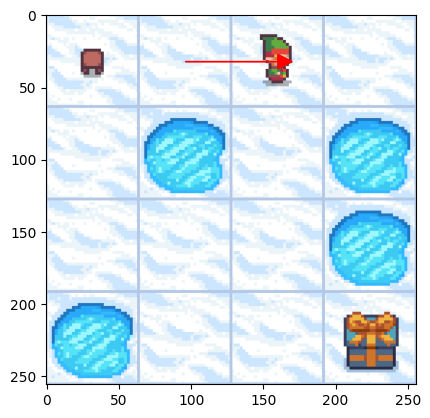

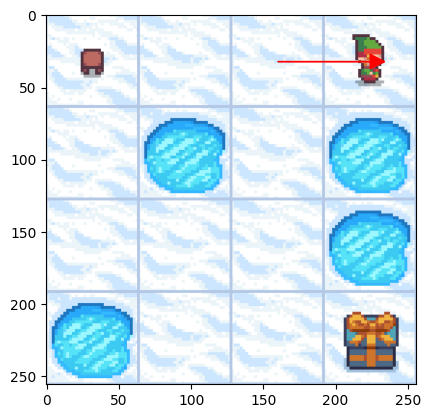

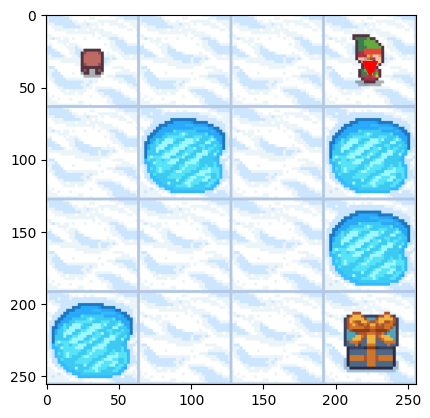

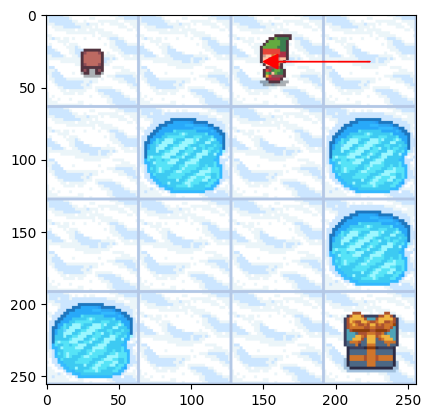

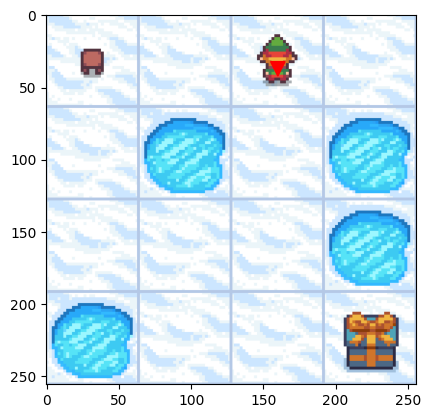

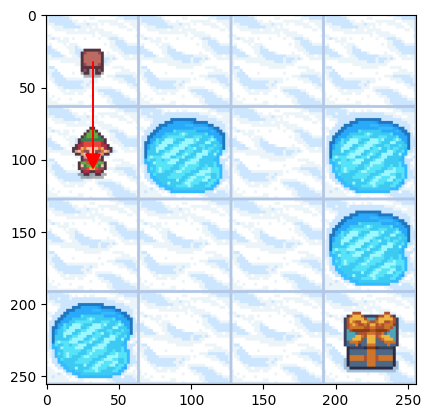

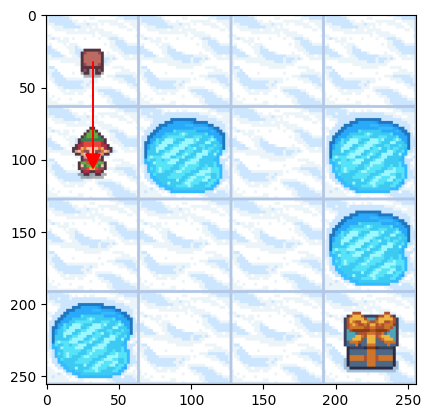

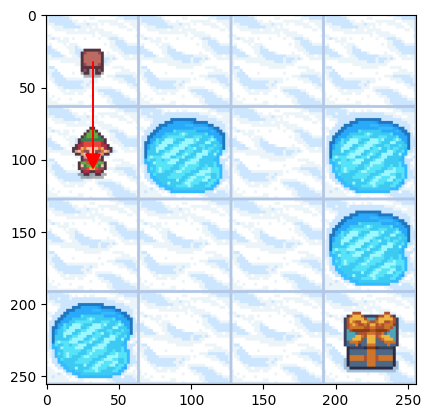

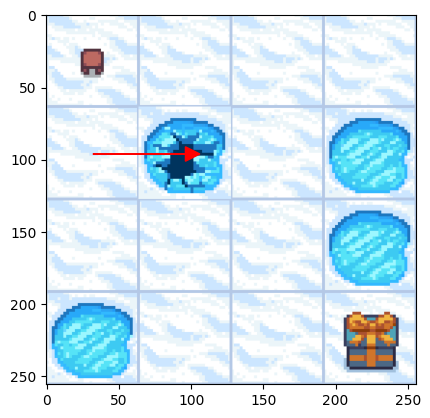

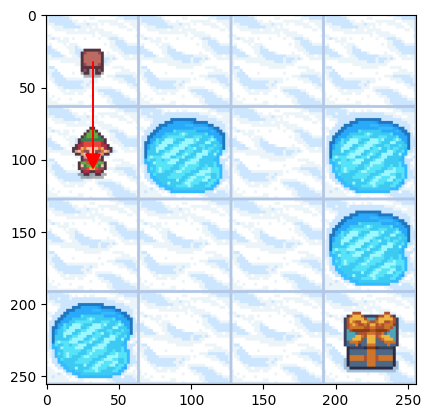

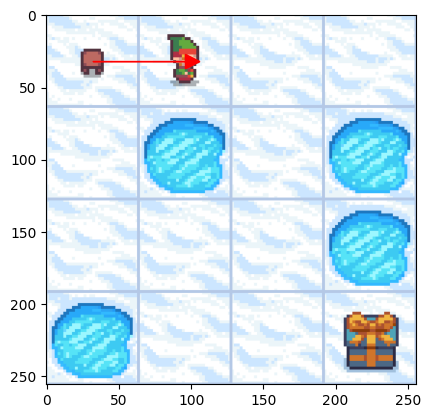

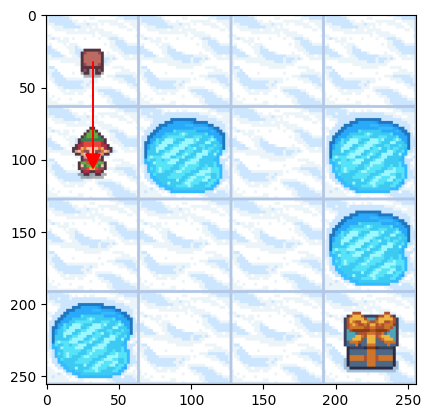

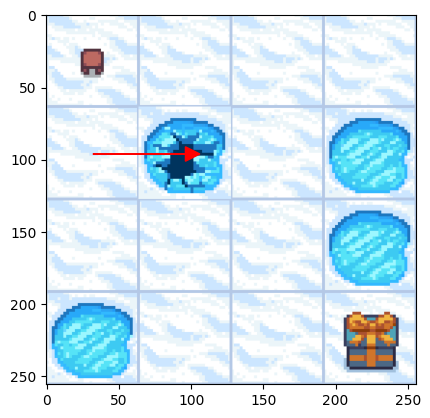

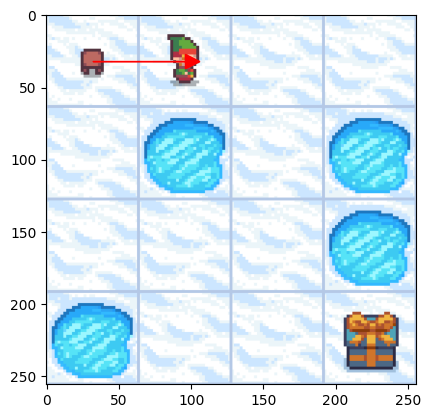

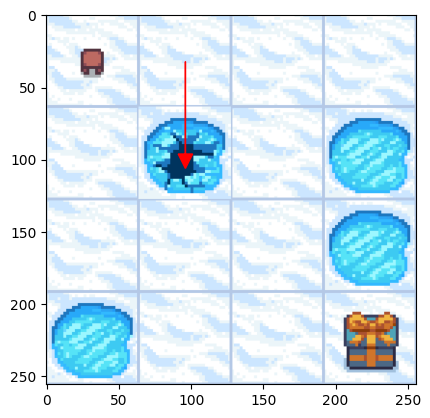

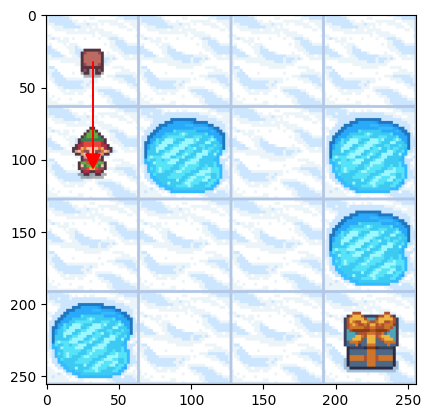

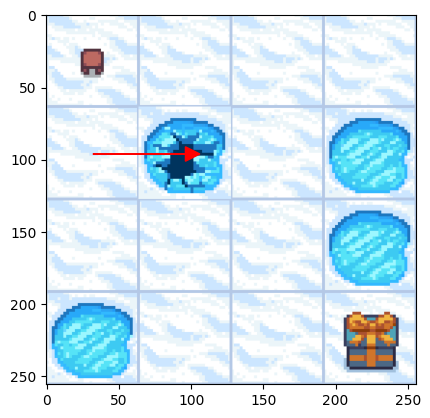

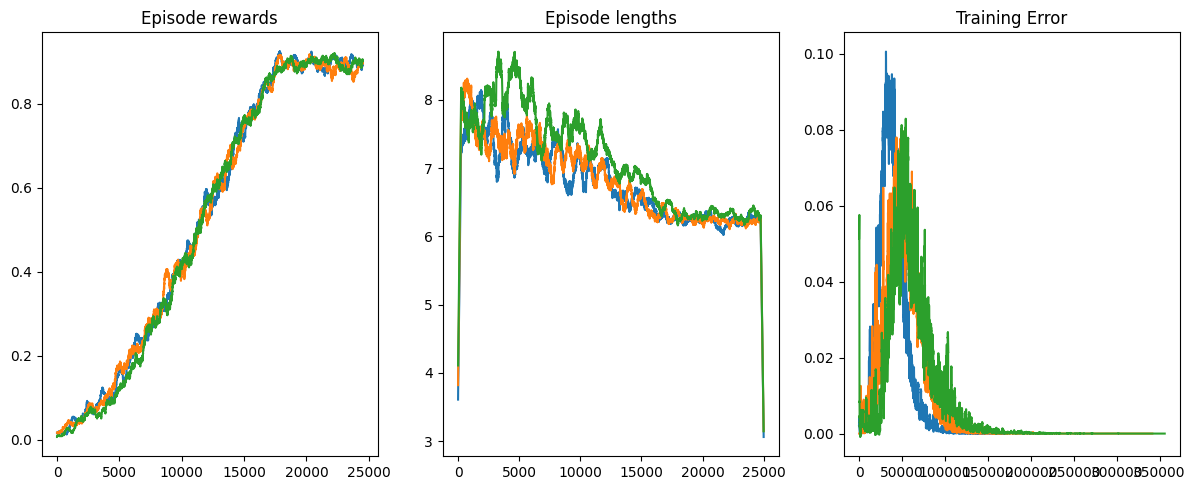

In [51]:
agent_hf = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)
env_hf = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
train(env_hf, agent_hf, n_episodes=25000, back_prop=True, human_feedback=True)

plot_stats([(env_baseline, agent_baseline), (env_backprop, agent_backprop), (env_hf, agent_hf)])

defaultdict(<function IRLAgent.__init__.<locals>.<lambda> at 0x7fbf799208b0>, {4: array([0.77328445, 0.81450625, 0.        , 0.7350795 ]), 0: array([0.73509189, 0.77378094, 0.77378094, 0.73509189]), 1: array([0.73509189, 0.        , 0.81450625, 0.77378094]), 2: array([0.77378094, 0.857375  , 0.77378094, 0.81450625]), 5: array([0., 0., 0., 0.]), 8: array([0.81270742, 0.        , 0.857375  , 0.77152222]), 12: array([0., 0., 0., 0.]), 3: array([0.81450625, 0.        , 0.77344914, 0.77282633]), 7: array([0., 0., 0., 0.]), 6: array([0.        , 0.9025    , 0.        , 0.81450625]), 9: array([0.81333043, 0.90096546, 0.9025    , 0.        ]), 13: array([0.        , 0.88145925, 0.95      , 0.83953941]), 10: array([0.857375, 0.95    , 0.      , 0.857375]), 14: array([0.90249999, 0.95      , 1.        , 0.9025    ]), 11: array([0., 0., 0., 0.]), 15: array([0., 0., 0., 0.])})


AttributeError: 'numpy.ndarray' object has no attribute 'cmap'

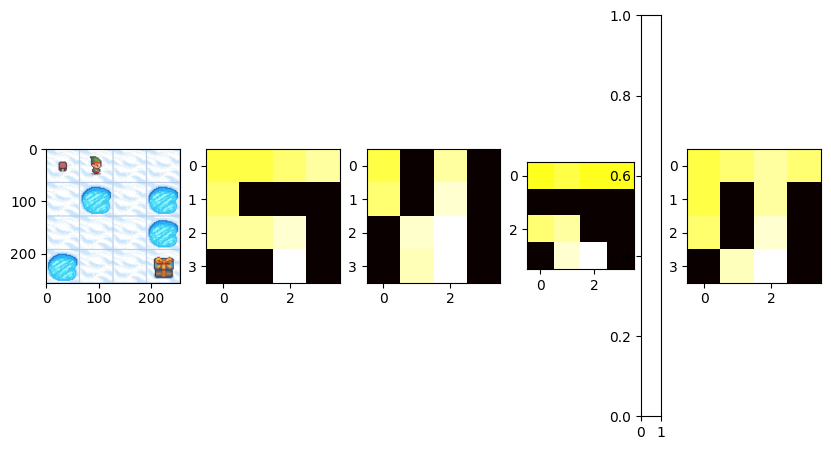

In [64]:
import seaborn as sns

print(agent_hf.q_values)
final_q_values = np.zeros([4,4,4])
for key, val in agent_hf.q_values.items():
    col = key % 4
    row = key // 4

    final_q_values[row, col] = val

fig, ax = plt.subplots(1,5, figsize=(10, 10))
ax[0].imshow(img)
for i in range(4):
    im = ax[i+1].imshow(final_q_values[:, :, i], cmap='hot', interpolation='nearest')
    
    if i == 3:
        cbar = ax[3].figure.colorbar(im, ax = ax[3])


In [ ]:
import os
import glob

def delete_files_in_directory(directory_path):
   try:
     files = glob.glob(os.path.join(directory_path, '*'))
     for file in files:
       if os.path.isfile(file):
         os.remove(file)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")

In [ ]:
import cv2

step_count = 0

# play one episode
obs, info = env.reset()
done = False

img = env.render()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
delete_files_in_directory("taxi_agent")
cv2.imwrite(f"taxi_agent/0.png", img)

while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    # agent.update(obs, action, reward, terminated, next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

    img = env.render()
    step_count += 1

    # print(step_count)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"taxi_agent/{step_count}.png", img)

!ffmpeg -framerate 4 -i 'taxi_agent/%d.png' -c:v libx264 -preset slow -tune stillimage -crf 24 -vf format=yuv420p -t 10 -movflags +faststart -y output.mp4

from IPython.display import Video

Video("output.mp4")

All files deleted successfully.
ffmpeg version 4.4.2-0ubuntu0.22.04.1+esm3 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1+esm3 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvi